# 📘 Progress Callbacks for Optimization Monitoring> Monitor optimization progress with progress bars, logging, and early stopping⏱️ **15-20 minutes** | 📊 **Level: ●●○ Intermediate** | 🏷️ **Feature Demo**---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/notebooks/05_feature_demos/callbacks_demo.ipynb)


In [1]:
# @title Install NLSQ (run once in Colab)
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab - installing NLSQ...")
    !pip install -q nlsq
    print("✅ NLSQ installed successfully!")
else:
    print("Not running in Colab - assuming NLSQ is already installed")

Not running in Colab - assuming NLSQ is already installed


## 🎯 Learning ObjectivesAfter this tutorial, you'll be able to:1. Use `ProgressBar` for real-time optimization monitoring2. Log optimization history with `IterationLogger`3. Prevent wasted iterations with `EarlyStopping`4. Combine multiple callbacks using `CallbackChain`5. Create custom callbacks for specialized needs---

## 🔬 Feature Overview**What problem does this solve?**- Long-running fits can appear frozen without feedback- Debugging requires iteration-level details- Optimization may continue unnecessarily after convergence**Available callbacks:**- `ProgressBar`: tqdm-based progress tracking- `IterationLogger`: Detailed logging to file- `EarlyStopping`: Stop when no improvement detected- `CallbackChain`: Combine multiple callbacks- `CallbackBase`: Base class for custom callbacks---

## Setup

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

In [3]:
from IPython.display import display

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from nlsq import curve_fit
from nlsq.callbacks import (
    CallbackBase,
    CallbackChain,
    EarlyStopping,
    IterationLogger,
    ProgressBar,
)


def exponential_decay(x, amplitude, rate, offset):
    return amplitude * jnp.exp(-rate * x) + offset

# Generate sample data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y_true = 100 * np.exp(-0.5 * x) + 10
y = y_true + np.random.normal(0, 3, size=len(x))

## Example 1: Simple Progress BarMonitor optimization progress with a visual progress bar.

In [5]:
# Create progress bar callback
callback = ProgressBar(max_nfev=50, desc="Fitting exponential")

# Fit with progress bar
popt, pcov = curve_fit(
    exponential_decay, x, y,
    p0=[80, 0.4, 5],
    callback=callback,
    max_nfev=50)

callback.close()

print(f'✓ Fitted: amplitude={popt[0]:.2f}, rate={popt[1]:.3f}, offset={popt[2]:.2f}')

/home/wei/Documents/GitHub/NLSQ/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=50


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=2971.9229613477737 | grad_norm=1.8979e+04 | nfev=1


Fitting exponential:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting exponential:   0%|          | 0/50 [00:00<?, ?it/s, cost=3.775535e+02, grad=1.898e+04, iter=1]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=377.5534806133975 | grad_norm=75.3272 | step=80.15709575577199 | nfev=2


Fitting exponential:   4%|▍         | 2/50 [00:00<00:01, 37.06it/s, cost=3.488163e+02, grad=7.533e+01, iter=2]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=348.81631735941266 | grad_norm=71.3770 | step=80.15709575577199 | nfev=3


Fitting exponential:   6%|▌         | 3/50 [00:00<00:00, 48.95it/s, cost=3.487993e+02, grad=7.138e+01, iter=3]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=348.7992986967673 | grad_norm=0.1522 | step=80.15709575577199 | nfev=4


Fitting exponential:   8%|▊         | 4/50 [00:00<00:00, 58.14it/s, cost=3.487993e+02, grad=1.522e-01, iter=4]

PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.289246s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=348.7993 | elapsed=1.289s | final_gradient_norm=0.0026


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=2.091912s


INFO:nlsq.curve_fit:Curve fit completed total_time=2.0919 | final_cost=697.5986 | covariance_warning=False


Fitting exponential:  10%|█         | 5/50 [00:00<00:02, 21.56it/s, cost=3.487993e+02, grad=1.522e-01, iter=4]

✓ Fitted: amplitude=101.49, rate=0.529, offset=10.45


## Example 2: Iteration LoggingLog detailed optimization progress to a file for later analysis.

In [6]:
# Create logging callback
callback = IterationLogger(
    filename='optimization.log',
    mode='w',
    log_params=True  # Include parameter values
)

# Fit with logging
popt, pcov = curve_fit(
    exponential_decay, x, y,
    p0=[80, 0.4, 5],
    callback=callback,
    max_nfev=50)

callback.close()

print('✓ Log written to optimization.log')
print('First few lines:')
with open('optimization.log') as f:
    print(''.join(f.readlines()[:10]))

INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=50


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=2971.9229613477737 | grad_norm=1.8979e+04 | nfev=1


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=377.5534806133975 | grad_norm=75.3272 | step=80.15709575577199 | nfev=2


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=348.81631735941266 | grad_norm=71.3770 | step=80.15709575577199 | nfev=3


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=348.7992986967673 | grad_norm=0.1522 | step=80.15709575577199 | nfev=4


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.222975s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=348.7993 | elapsed=0.223s | final_gradient_norm=0.0026


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.499451s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.4995 | final_cost=697.5986 | covariance_warning=False


✓ Log written to optimization.log
First few lines:
NLSQ Optimization Log
Started: 2026-01-06 11:01:57

Iter    1 | Cost: 3.775535e+02 | Grad: 1.898e+04 | NFev:    2 | Time: 0.00s | Params: [99.345633,  0.541293, 11.578664]
Iter    2 | Cost: 3.488163e+02 | Grad: 7.533e+01 | NFev:    3 | Time: 0.01s | Params: [101.488582,   0.528776,  10.460917]
Iter    3 | Cost: 3.487993e+02 | Grad: 7.138e+01 | NFev:    4 | Time: 0.02s | Params: [101.493062,   0.528967,  10.448703]
Iter    4 | Cost: 3.487993e+02 | Grad: 1.522e-01 | NFev:    5 | Time: 0.03s | Params: [101.493192,   0.52897 ,  10.448796]



## Example 3: Early StoppingPrevent wasted iterations by stopping when optimization stalls.

In [7]:
# Create early stopping callback
callback = EarlyStopping(
    patience=10,       # Stop after 10 iterations without improvement
    min_delta=1e-6,    # Minimum improvement threshold
    verbose=True)

# Fit with early stopping
popt, pcov = curve_fit(
    exponential_decay, x, y,
    p0=[80, 0.4, 5],
    callback=callback,
    max_nfev=1000  # Set high, early stopping prevents waste
)

print(f'✓ Fitted: amplitude={popt[0]:.2f}, rate={popt[1]:.3f}, offset={popt[2]:.2f}')

INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=1000


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=2971.9229613477737 | grad_norm=1.8979e+04 | nfev=1


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=377.5534806133975 | grad_norm=75.3272 | step=80.15709575577199 | nfev=2


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=348.81631735941266 | grad_norm=71.3770 | step=80.15709575577199 | nfev=3


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=348.7992986967673 | grad_norm=0.1522 | step=80.15709575577199 | nfev=4


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.216340s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=348.7993 | elapsed=0.216s | final_gradient_norm=0.0026


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.480929s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.4809 | final_cost=697.5986 | covariance_warning=False


✓ Fitted: amplitude=101.49, rate=0.529, offset=10.45


## Example 4: Combining Multiple CallbacksUse `CallbackChain` to combine progress bar, logging, and early stopping.

In [8]:
# Combine multiple callbacks
callback = CallbackChain(
    ProgressBar(max_nfev=50, desc="Optimizing"),
    IterationLogger('combined.log', log_params=False),
    EarlyStopping(patience=10, verbose=False))

# Fit with callback chain
popt, pcov = curve_fit(
    exponential_decay, x, y,
    p0=[80, 0.4, 5],
    callback=callback,
    max_nfev=50)

callback.close()

print('✓ All callbacks executed!')
print('Check combined.log for iteration history')

INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=50


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=2971.9229613477737 | grad_norm=1.8979e+04 | nfev=1


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

Optimizing:   0%|          | 0/50 [00:00<?, ?it/s, cost=3.775535e+02, grad=1.898e+04, iter=1]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=377.5534806133975 | grad_norm=75.3272 | step=80.15709575577199 | nfev=2


Optimizing:   4%|▍         | 2/50 [00:00<00:00, 293.99it/s, cost=3.488163e+02, grad=7.533e+01, iter=2]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=348.81631735941266 | grad_norm=71.3770 | step=80.15709575577199 | nfev=3


Optimizing:   6%|▌         | 3/50 [00:00<00:00, 233.40it/s, cost=3.487993e+02, grad=7.138e+01, iter=3]

PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=348.7992986967673 | grad_norm=0.1522 | step=80.15709575577199 | nfev=4


Optimizing:   8%|▊         | 4/50 [00:00<00:00, 222.47it/s, cost=3.487993e+02, grad=1.522e-01, iter=4]

PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.206455s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=348.7993 | elapsed=0.206s | final_gradient_norm=0.0026


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.534451s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.5345 | final_cost=697.5986 | covariance_warning=False


Optimizing:  10%|█         | 5/50 [00:00<00:00, 50.10it/s, cost=3.487993e+02, grad=1.522e-01, iter=4] 

✓ All callbacks executed!
Check combined.log for iteration history


## Example 5: Custom CallbackCreate specialized callbacks by subclassing `CallbackBase`.

In [9]:
class BestParameterTracker(CallbackBase):
    """Custom callback to track best parameters."""

    def __init__(self):
        self.best_cost = np.inf
        self.best_params = None
        self.history = []

    def __call__(self, iteration, cost, params, info):
        """Track best parameters."""
        self.history.append({'iter': iteration, 'cost': cost})

        if cost < self.best_cost:
            self.best_cost = cost
            self.best_params = params.copy()
            print(f'  → New best at iter {iteration}: cost={cost:.6f}')

    def get_best(self):
        return self.best_params, self.best_cost

# Use custom callback
tracker = BestParameterTracker()
popt, pcov = curve_fit(
    exponential_decay, x, y,
    p0=[80, 0.4, 5],
    callback=tracker,
    max_nfev=50)

best_params, best_cost = tracker.get_best()
print(f'\n✓ Best cost: {best_cost:.6f}')
print(f'✓ Final params match best: {np.allclose(popt, best_params)}')

INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=100 | method=trf | solver=auto | batch_size=None | has_bounds=False | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


INFO:nlsq.optimizer.trf:Starting TRF optimization (no bounds) n_params=3 | n_residuals=100 | max_nfev=50


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=0 | cost=2971.9229613477737 | grad_norm=1.8979e+04 | nfev=1


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=1 | cost=377.5534806133975 | grad_norm=75.3272 | step=80.15709575577199 | nfev=2


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=2 | cost=348.81631735941266 | grad_norm=71.3770 | step=80.15709575577199 | nfev=3


PERFORMANCE:nlsq.optimizer.trf:Iteration iter=3 | cost=348.7992986967673 | grad_norm=0.1522 | step=80.15709575577199 | nfev=4


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.226130s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=348.7993 | elapsed=0.226s | final_gradient_norm=0.0026


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.552706s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.5527 | final_cost=697.5986 | covariance_warning=False


  → New best at iter 1: cost=377.553481
  → New best at iter 2: cost=348.816317
  → New best at iter 3: cost=348.799299
  → New best at iter 4: cost=348.799298

✓ Best cost: 348.799298
✓ Final params match best: True


## Visualize Results

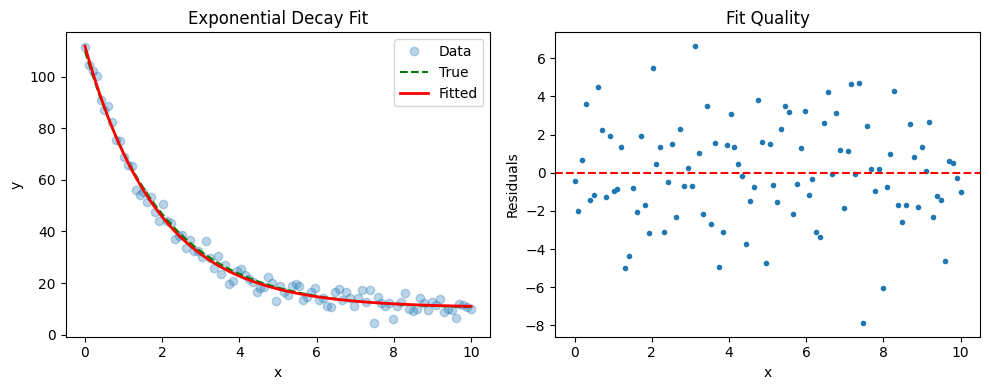

In [10]:
y_fit = exponential_decay(x, *popt)

fig = plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(x, y, 'o', alpha=0.3, label='Data')
plt.plot(x, y_true, 'g--', label='True')
plt.plot(x, y_fit, 'r-', linewidth=2, label='Fitted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Exponential Decay Fit')

plt.subplot(122)
plt.plot(x, y - y_fit, '.')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('Fit Quality')

plt.tight_layout()
plt.tight_layout()
plt.show()


## 💡 Key Insights1. **Progress bars** provide real-time feedback for long-running fits2. **Iteration logging** enables detailed post-analysis and debugging3. **Early stopping** saves computation when optimization stalls4. **Callback chains** combine multiple monitoring strategies5. **Custom callbacks** enable specialized monitoring for your use case---## 📚 Best Practices- Use `ProgressBar` for interactive work (notebooks, scripts)- Use `IterationLogger` for production/automated workflows- Set `patience` in `EarlyStopping` based on problem complexity- Combine callbacks with `CallbackChain` for comprehensive monitoring- Extend `CallbackBase` for custom visualization or metrics---## 🎓 Next Steps- Try callbacks on your own optimization problems- Create custom callbacks for domain-specific metrics- Explore callback integration with logging frameworks- Use callbacks to implement adaptive optimization strategies---